In [5]:
import numpy as np # primary math library
import matplotlib.pyplot as plt # primary plotting library
%matplotlib inline

import nelpy as nel # should be installed using pip install nelpy

import warnings
#warnings.filterwarnings("ignore") # useful to prevent excess nelpy warnings

In [6]:
dataroot = '/Users/ckemere/Development/Data/Frank/';

In [7]:
import os

filename = os.path.join(dataroot,'FrankLabData.nel')
import pandas as pd
import nelpy.io
jar = nel.load_pkl(filename)

data = jar.data
tetinfo = jar.tetinfo
cellinfo = jar.cellinfo
taskinfo = jar.taskinfo
del jar


# Calculate tuning curves for all neurons for an example animal

In [9]:
from numpy import unravel_index

anim = 'Bon'
novel_epochs = [1,3]
familiar_epochs = 5

use_novel = True

epochs = []
if use_novel:
    epochs = epochs + novel_epochs
else:
    epochs = epochs + familiar_epochs

    
sigma_500ms = 0.5 # Smoothing for speed calculation
# Bin sizes are 500 ms, and then we slide
ds_run = 0.250 # 250 ms
ds_50ms = 0.05

sigma_250ms = 0.25 # 250 ms spike smoothing


# Bins for tuning curves
x_extents = [10,160] # Read these off of maze figure above
nx = np.diff(x_extents)/2.5 # plan for 5 cm bins

y_extents = [20,190]
ny = np.diff(y_extents)/2.5

min_duration = 1 # require that estimation periods be at least 1 second long

# Smoothing standard deviation
sigma_tc = 2.5 # tuning curve smoothing std in cm
min_spikes = 5

PFCenters = {}
TuningCurves = {}

for day, daydata in data[anim].items():
    # The animal "Bon" had good data on day 3
    S = daydata['spikes']
    pos = daydata['pos']

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        speed = nel.utils.dxdt_AnalogSignalArray(pos[epochs,:], smooth=True, sigma=sigma_500ms)

    # get_run_epochs is a utility function which wraps a speed threshold. This finds periods where the speed
    #   is greater than v2 and reaches at least a maximum of v1.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        run_epochs = nel.utils.get_run_epochs(speed, v1=8, v2=3) # original choice
        run_epochs = pos[epochs,:].support.intersect(run_epochs)    
    
    st_run = S[run_epochs]
    
    # bin, smooth and re-bin:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        bst_run = st_run.bin(ds=ds_50ms).smooth(sigma=sigma_250ms, inplace=True).rebin(w=ds_run/ds_50ms)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tc = nel.TuningCurve2D(bst=bst_run, extern=pos, 
                               ext_xmin=x_extents[0], ext_xmax=x_extents[1], 
                               ext_ymin=y_extents[0], ext_ymax=y_extents[1],
                               ext_nx=nx, ext_ny=ny,
                               sigma=sigma_tc, min_duration=1)

    TuningCurves[day] = tc
    PFCenters[day] = []

    for idx, pf in enumerate(tc.ratemap):
        placefield = pf.T
        peak = unravel_index(placefield.squeeze().argmax(),placefield.shape)
        PFCenters[day].append([idx, placefield.max(), peak[0], peak[1]])
        
    


In [42]:
# LOAD 3 sigma ripples
jar = nel.load_pkl('FrankLabData-BonConFra-no-eeg.nel')
swrdata = jar.data

SWREpochs = {}
for day, daydata in swrdata[anim].items():
    SWREpochs[int(day.strip('Day'))] = daydata['ripples_all_tetrodes_CA1']
del swrdata
del jar

# Plot an example tuning curve

In [43]:
day = 3

/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


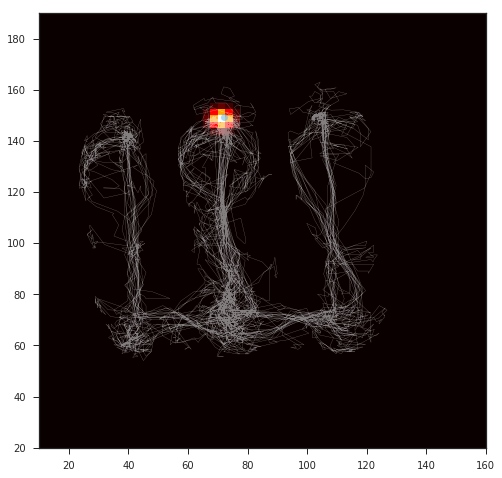

In [44]:
import nelpy.plotting as npl

tc = TuningCurves[day]
xx_mid = tc.xbin_centers
yy_mid = tc.ybin_centers

S = data[anim][day]['spikes']
pos = data[anim][day]['pos']

speed = nel.utils.dxdt_AnalogSignalArray(pos[epochs,:], smooth=True, sigma=sigma_500ms)
run_epochs = nel.utils.get_run_epochs(speed, v1=8, v2=3) # original choice
run_epochs = pos[epochs,:].support.intersect(run_epochs)  
runpos = pos[run_epochs]


fig, ax = plt.subplots(1,1, figsize = (8, 8))

xvals, yvals = runpos.simplify(n_points=5000).asarray().yvals

nidx = 2
xspks, yspks = runpos.asarray(at=S[run_epochs].time[nidx]).yvals

ax.set_aspect('equal')
placefield = tc.ratemap[nidx]
npl.imagesc(x=xx_mid, y=yy_mid, data=placefield.T, cmap=plt.cm.hot, ax=ax)
ax.plot(xvals, yvals, lw=0.25, color='w', alpha=0.5)
ax.plot(xspks, yspks, 'o', color=npl.colors.sweet.blue, alpha=0.5)



In [45]:
filename = os.path.join(dataroot,'FrankLabCenterArm.nel')
jar = nel.load_pkl(filename)
NovelCenterBounds = jar.NovelCenterBounds['Bon']
FamiliarCenterBounds = jar.FamiliarCenterBounds['Bon']

(38, 8) 38 (38,) (38,) (38,) (38,)
(74, 8) 74 (74,) (74,) (74,) (74,)
(60, 8) 60 (60,) (60,) (60,) (60,)
(67, 8) 67 (67,) (67,) (67,) (67,)
(62, 8) 62 (62,) (62,) (62,) (62,)
(49, 8) 49 (49,) (49,) (49,) (49,)
(64, 8) 64 (64,) (64,) (64,) (64,)
(61, 8) 61 (61,) (61,) (61,) (61,)


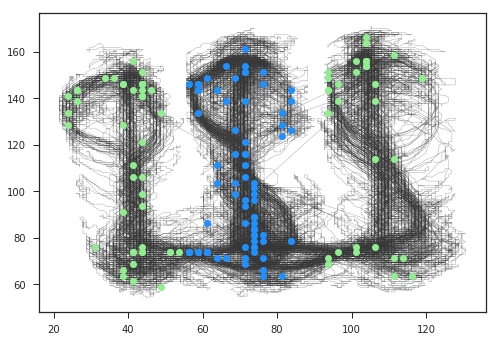

In [46]:
fig, ax = plt.subplots()
PF_data = {}

PF_arm = {}

if use_novel:
    CenterBounds = NovelCenterBounds
else:
    CenterBounds = FamiliarCenterBounds

for day, daydata in data[anim].items():
    # The animal "Bon" had good data on day 3
    S = daydata['spikes']
    pos = daydata['pos']
    # Find placefield centers
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tvals, vals = pos[epochs,:].asarray() # Access timestamps and channel data as numpy arrays
    xvals, yvals = vals # Access two channels as x and y
    ax.plot(xvals, yvals, lw=0.5, c='0.2', alpha=0.4)

for day, daydata in data[anim].items():
    maxrate = np.array(PFCenters[day])
    maxrate = maxrate[:,1]
    p = np.array(PFCenters[day],dtype=int)
    pfcenters = np.vstack((tc.xbin_centers[p[:,3]], tc.ybin_centers[p[:,2]])).T

    # Find left and right arm PFs as the direction of the projection vector
    #   from the dividing plane and the placefield center
    left = (np.cross(pfcenters-CenterBounds[0],CenterBounds[5]-CenterBounds[0]) < 0)
    right = (np.cross(pfcenters-CenterBounds[2],CenterBounds[3]-CenterBounds[2]) > 0)
    center = np.logical_and(np.logical_not(left), np.logical_not(right))
    
    left = np.logical_and(left, maxrate > 2)
    right = np.logical_and(right, maxrate > 2)
    center = np.logical_and(center, maxrate > 2)
    inactive = maxrate <= 2

    ax.plot(pfcenters[left,0], pfcenters[left,1],'o',c='lightgreen')
    ax.plot(pfcenters[right,0], pfcenters[right,1],'o',c='lightgreen')
    ax.plot(pfcenters[center,0], pfcenters[center,1],'o',c='dodgerblue')
    
    PF_data[day] = np.column_stack((np.array(PFCenters[day]), np.array(inactive), 
                              np.array(center), np.array(left), np.array(right)));

    S = daydata['spikes']
    print(PF_data[day].shape, S.n_units, left.shape, right.shape, center.shape, inactive.shape)



(7308,)


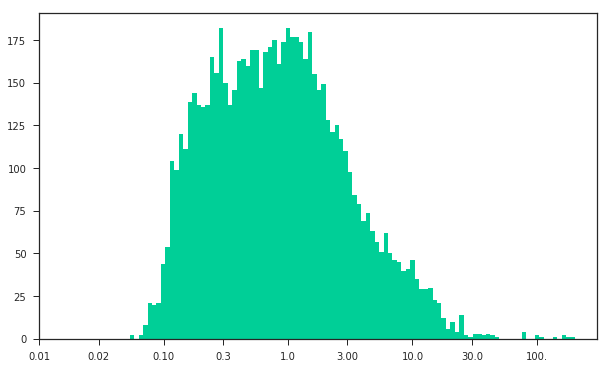

In [48]:
import nelpy.plotting as npl
# Set default figure aesthetics
npl.setup(font_scale=1)

post_sleep_epochs = [ep+1 for ep in epochs]
inter_swr_intervals = []
for day, swr_eps in SWREpochs.items():
    for ep in post_sleep_epochs:
        post_sleep_swr = swr_eps.intersect(pos.support[ep])
        swrtimes = post_sleep_swr.centers
        inter_swr_intervals.append(np.diff(swrtimes))

inter_swr_intervals = np.hstack(inter_swr_intervals)
print(inter_swr_intervals.shape)
with npl.FigureManager(show=True, figsize=(10, 6)) as (fig, ax):    
    ax.hist(np.log(inter_swr_intervals),bins=100);
    ax.set_xticks(np.log([0.01,0.03,0.1,0.3,1,3,10,30,100]))
    ax.set_xticklabels(np.exp(ax.get_xticks()).astype('|U4'))

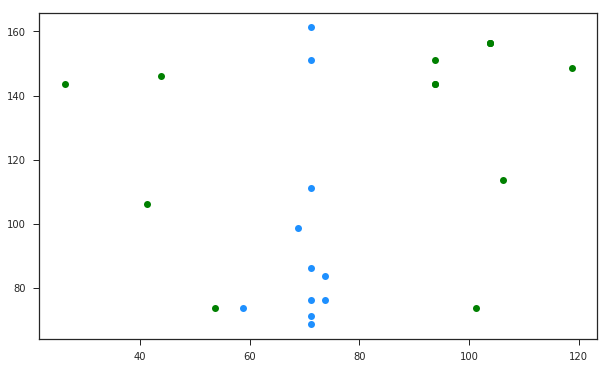

In [49]:
with npl.FigureManager(show=True, figsize=(10, 6)) as (fig, ax):    
    maxrate = np.array(PFCenters[day])
    maxrate = maxrate[:,1]
    p = np.array(PFCenters[day],dtype=int)
    pfcenters = np.vstack((tc.xbin_centers[p[:,3]], tc.ybin_centers[p[:,2]])).T

    # Find left and right arm PFs
    left = (np.cross(pfcenters-CenterBounds[0],CenterBounds[5]-CenterBounds[0]) < 0)
    right = (np.cross(pfcenters-CenterBounds[2],CenterBounds[3]-CenterBounds[2]) > 0)
    center = np.logical_and(np.logical_not(left), np.logical_not(right))
    
    left = np.logical_and(left, maxrate > 2)
    right = np.logical_and(right, maxrate > 2)
    center = np.logical_and(center, maxrate > 2)
    inactive = maxrate <= 2

    ax.plot(pfcenters[left,0], pfcenters[left,1],'o',c='green')
    ax.plot(pfcenters[right,0], pfcenters[right,1],'o',c='green')
    ax.plot(pfcenters[center,0], pfcenters[center,1],'o',c='dodgerblue')


/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


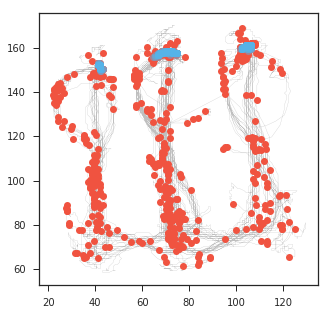

In [50]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
swr_eps = SWREpochs[day]
#for ep in epochs:
pos = data[anim][day]['pos']
speed = nel.utils.dxdt_AnalogSignalArray(pos[epochs,:], smooth=True, sigma=sigma_500ms)

not_still_epochs = nel.utils.get_run_epochs(speed, v1=8, v2=3) # bound epochs down to 1 cm/s
still_epochs = pos[epochs,:].support.intersect(not_still_epochs.complement()) 
still_pos = pos[epochs,:].support.intersect(still_epochs)

all_swr = swr_eps.intersect(pos[epochs,:].support)
allswrtimes = all_swr.centers
still_swr = swr_eps.intersect(still_epochs)
stillswrtimes = still_swr.centers

posx, posy = pos[epochs,:].asarray().yvals 
ax.plot(posx, posy, lw=0.25, color='gray', alpha=0.5)
xswr, yswr = pos.asarray(at=allswrtimes).yvals
ax.plot(xswr, yswr, 'o', color=npl.colors.sweet.red)
xswr1, yswr1 = pos.asarray(at=stillswrtimes).yvals
ax.plot(xswr1, yswr1, 'o', color=npl.colors.sweet.blue, alpha=0.5)





In [52]:
import pandas as pd

swr_table = []

for day, swr_eps in SWREpochs.items():
    for ep in epochs:
        S = data[anim][day]['spikes']
        print(day,S.n_units, PF_data[day].shape)
        
        pos = data[anim][day]['pos']
        speed = nel.utils.dxdt_AnalogSignalArray(pos[epochs,:], smooth=True, sigma=sigma_500ms)

        not_still_epochs = nel.utils.get_run_epochs(speed, v1=8, v2=3) # bound epochs down to 1 cm/s
        still_epochs = pos[epochs,:].support.intersect(not_still_epochs.complement()) 
        still_pos = pos[epochs,:].support.intersect(still_epochs)

        all_swr = swr_eps.intersect(pos[epochs,:].support)
        allswrtimes = all_swr.centers
        still_swr = swr_eps.intersect(still_epochs)
        stillswrtimes = still_swr.centers

        swr_spikes = S[still_swr]
 
        isi = np.insert(np.diff(swrtimes),0,-np.nan)
        for idx, swr in enumerate(swr_spikes):
            swr_table.append([
                swrtimes[idx],
                isi[idx],
                swr[:,np.argwhere(PF_data[day][:,4])].n_active,
                swr[:,np.argwhere(PF_data[day][:,5])].n_active,
                swr[:,np.argwhere(PF_data[day][:,6])].n_active,
                swr[:,np.argwhere(PF_data[day][:,7])].n_active,
            ])

swr_df = pd.DataFrame(swr_table,columns=['time','isi','inactive','center','left','right'])
        


2 38 (38, 8)


/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


2 38 (38, 8)


/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


3 74 (74, 8)


/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


3 74 (74, 8)


/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


4 60 (60, 8)


/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


4 60 (60, 8)


/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


5 67 (67, 8)


/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


5 67 (67, 8)


/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


6 62 (62, 8)


/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


6 62 (62, 8)


/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


7 49 (49, 8)


/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


7 49 (49, 8)


/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


8 64 (64, 8)


/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


8 64 (64, 8)


/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


9 61 (61, 8)


/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


9 61 (61, 8)


/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


In [53]:
left_isi = []
right_isi = []
center_isi = []
inactive_isi = []

last_left = np.nan
last_right = np.nan
last_center = np.nan
last_inactive = np.nan

for idx, row in swr_df.iterrows():
    if np.isnan(row['isi']):
        last_left = np.nan
        last_right = np.nan
        last_center = np.nan
        last_inactive = np.nan

    if row['left'] > 0:
        if ~np.isnan(last_left):
            left_isi.append( (row['time'] - last_left)/row['isi'] )
        last_left = row['time']
        
    if row['right'] > 0:
        if ~np.isnan(last_right):
            right_isi.append( (row['time'] - last_right)/row['isi'] )
        last_right = row['time']
        
    if row['center'] > 0:
        if ~np.isnan(last_center):
            center_isi.append(row['time'] - last_center)
        last_center = row['time']
        
    if row['inactive'] > 0:
        if ~np.isnan(last_inactive):
            inactive_isi.append(row['time'] - last_inactive)
        last_inactive = row['time']


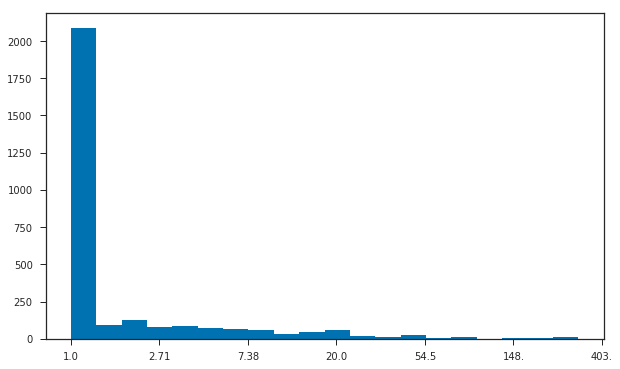

In [54]:
import seaborn as sns
sns.set_palette('colorblind')
with npl.FigureManager(show=True, figsize=(10, 6)) as (fig, ax):
    #sns.distplot(np.log(inter_swr_intervals),hist=True,norm_hist=True,bins=50,label='SWR');
    #sns.distplot(np.log(inactive_isi),hist=True,norm_hist=True,bins=25,label='Inactive');
    #sns.distplot(np.log(center_isi),hist=True,norm_hist=True,bins=50,label='Center');
    #sns.distplot(np.log(left_isi),hist=True,norm_hist=True,bins=25,label='Left');
    #sns.distplot(np.log(right_isi),hist=True,norm_hist=True,bins=25,label='Right');
    ax.hist(np.log(right_isi+left_isi),bins=20,label='Same Arm');
    #ax.set_xticks(np.log([1,3,10,30,100,300,1000]))
    ax.set_xticklabels(np.exp(ax.get_xticks()).astype('|U4'))


# Decode each ripple's total position

In [55]:
swr_nspikes = []
for day, swr_eps in SWREpochs.items():
    swr_nspikes.append([])
    for ep in epochs:
        S = data[anim][day]['spikes']        
        pos = data[anim][day]['pos']
        
        all_swr = swr_eps.intersect(pos.support[ep])
        swr_spikes = S[all_swr]
        swrtimes = all_swr.centers
        
        for idx, swr in enumerate(swr_spikes):
            print(swr)
            break
        break
    break




<SpikeTrainArray at 0x1cc88ab048: 38 units> at 10000 Hz


# Plot firing rate maps of all neurons by detected arm center

/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support
/Users/ckemere/Development/Python/nelpy/nelpy/core/_analogsignalarray.py:560: UserWarning: ignoring signal outside of support


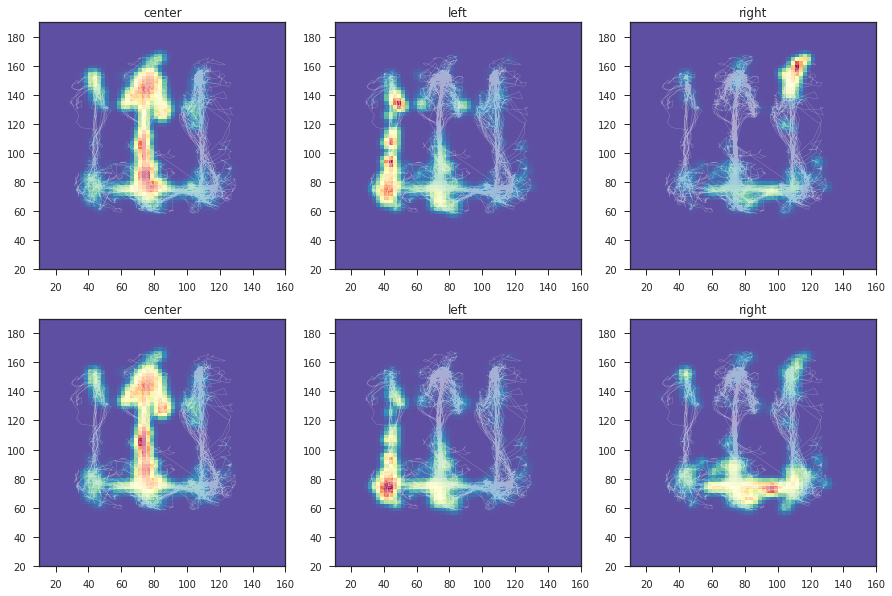

In [59]:
tc = TuningCurves[day]
xx_mid = tc.xbin_centers
yy_mid = tc.ybin_centers

S = data[anim][day]['spikes']
pos = data[anim][day]['pos']

speed = nel.utils.dxdt_AnalogSignalArray(pos[epochs,:], smooth=True, sigma=sigma_500ms)
run_epochs = nel.utils.get_run_epochs(speed, v1=8, v2=3) # original choice
run_epochs = pos[epochs,:].support.intersect(run_epochs)  
runpos = pos[run_epochs]
xvals, yvals = runpos.simplify(n_points=5000).asarray().yvals


fig, ax = plt.subplots(2, 3, figsize = (15, 10))
axis_order = ['center', 'left', 'right']
for idx, axis in enumerate(axis_order):    
    ax[0,idx].set_aspect('equal')
    all_pfs = tc.ratemap[PF_data[day][:,idx + 5]==1,:,:]
    norm_pfs = all_pfs.T / all_pfs.sum(axis=2).sum(axis=1)
    total_pfs = norm_pfs.mean(axis=2)
    npl.imagesc(x=xx_mid, y=yy_mid, data=total_pfs, cmap=plt.cm.Spectral_r, ax=ax[0,idx])
    ax[0,idx].plot(xvals, yvals, lw=0.25, color='w', alpha=0.5)
    ax[0,idx].set_title(axis)

    ax[1,idx].set_aspect('equal')
    all_pfs = tc.ratemap[PF_data[day][:,idx + 5]==1,:,:].sum(axis=0)
    npl.imagesc(x=xx_mid, y=yy_mid, data=all_pfs.T, cmap=plt.cm.Spectral_r, ax=ax[1,idx])
    ax[1,idx].plot(xvals, yvals, lw=0.25, color='w', alpha=0.5)
    ax[1,idx].set_title(axis)




In [73]:
ratemap = tc.ratemap
swr_eps = SWREpochs[day]
for ep in epochs:
    S = data[anim][day]['spikes']        
    pos = data[anim][day]['pos']

    all_swr = swr_eps.intersect(pos.support[ep])
    swr_spikes = S[all_swr]
    swrtimes = all_swr.centers

    for idx, swr in enumerate(swr_spikes):
        bayes_estimate = -ratemap.sum(axis=0).T + np.log(ratemap.T).dot(swr.n_spikes)
        # exp(-lambda) * lambda^k / 
        break
    break


#swr.n_spikes


# Define left and right pixels

In [ ]:

left_odds = (np.cross(pfcenters-CenterBounds[0],CenterBounds[5]-CenterBounds[0]) < 0)
right_odds = (np.cross(pfcenters-CenterBounds[2],CenterBounds[3]-CenterBounds[2]) > 0)



In [81]:
nx

array([ 60.])

In [95]:
left_pixels = np.zeros((int(nx),int(ny)))
right_pixels = np.zeros((int(nx),int(ny)))
for ix, x in enumerate(xx_mid):
    for iy, y in enumerate(yy_mid):
        left_pixels[ix,iy] = np.cross([x,y] - CenterBounds[0], CenterBounds[5]-CenterBounds[0]) < 0
        right_pixels[ix,iy] = np.cross([x,y] - CenterBounds[2], CenterBounds[3]-CenterBounds[2]) > 0


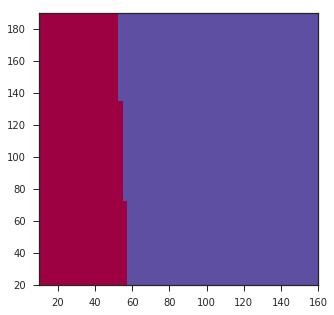

In [88]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.set_aspect('equal')
ax, img = npl.imagesc(x=xx_mid, y=yy_mid, data=left_pixels.T, cmap=plt.cm.Spectral_r, ax=ax)



13509.3207725


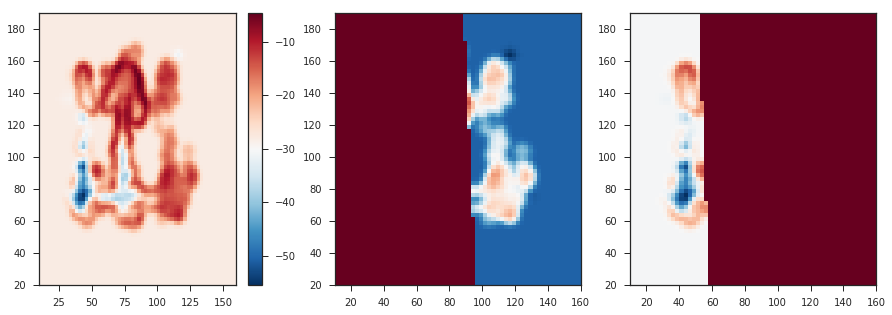

In [109]:

fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].set_aspect('equal')
ax[0], img = npl.imagesc(x=xx_mid, y=yy_mid, data=bayes_estimate, cmap=plt.cm.RdBu_r, ax=ax[0])
plt.colorbar(img, ax=ax[0])


ax[1].set_aspect('equal')
a, img = npl.imagesc(x=xx_mid, y=yy_mid, data=bayes_estimate * right_pixels.T, cmap=plt.cm.RdBu_r, ax=ax[1])

ax[2].set_aspect('equal')
a, img = npl.imagesc(x=xx_mid, y=yy_mid, data=bayes_estimate * left_pixels.T, cmap=plt.cm.RdBu_r, ax=ax[2])

left_odds = (bayes_estimate * left_pixels.T).sum()
right_odds = (bayes_estimate * right_pixels.T).sum()

print(left_odds-right_odds)


In [110]:
ratemap.shape

(38, 60, 68)

In [129]:
all_shuf_odds = []
all_true_odds = []
NN = ratemap.shape[0]

for idx, swr in enumerate(swr_spikes):
    if swr.n_active == 0:
        all_true_odds.append(0)
        all_shuf_odds.append(0)
        continue;
    bayes_estimate = -ratemap.sum(axis=0).T + np.log(ratemap.T).dot(swr.n_spikes)
    left_odds = (bayes_estimate * left_pixels.T).sum()
    right_odds = (bayes_estimate * right_pixels.T).sum()

    true_odds = left_odds - right_odds
    all_true_odds.append(true_odds)

    n_shuffles = 500
    shuf_odds = []
    for n in range(n_shuffles):
        shuf_rate = ratemap.copy()
        shuf_rate = shuf_rate[np.random.permutation(NN),:,:]
        shuf_est = -shuf_rate.sum(axis=0).T + np.log(shuf_rate.T).dot(swr.n_spikes)
        left_odds = (shuf_est * left_pixels.T).sum()
        right_odds = (shuf_est * right_pixels.T).sum()
        shuf_odds.append(left_odds - right_odds)
        

    all_shuf_odds.append(shuf_odds)
    print(idx)
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
56
57
58
59
60
61
62
63
65
69
70
71
72
73
74
75
76
77
79
80
81
82
83
84
85
86
88
90
91
92
93
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
122
123
124
125
126
128
129
130
131
132
133
134
135
136
137
138
139
140
141
143
144
145
146
147
148
149
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
174
175
176
177
179
181
184
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
209
210
211
212
213
214
215
216
218
220
221
222
223
224
225
226
227
228
229
230
233
234
235
237
238
239
242
243
244
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
264
265
266
268
269
270
271
272
273
274
275
276
277
278
279
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295


KeyboardInterrupt: 

In [128]:
swr.n_active

2

In [122]:
from scipy import stats

shuf_rat = []
for idx, t in enumerate(all_true_odds):
    shuf_rat.append(stats.percentileofscore(all_shuf_odds[idx],t))

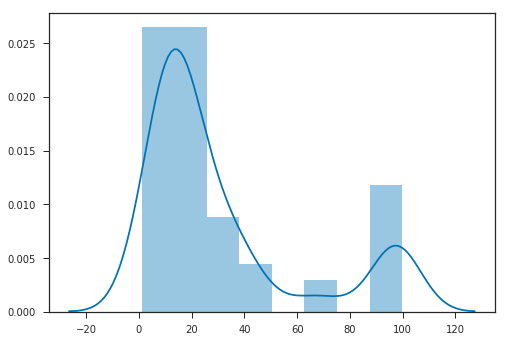

In [124]:
sns.distplot(shuf_rat)

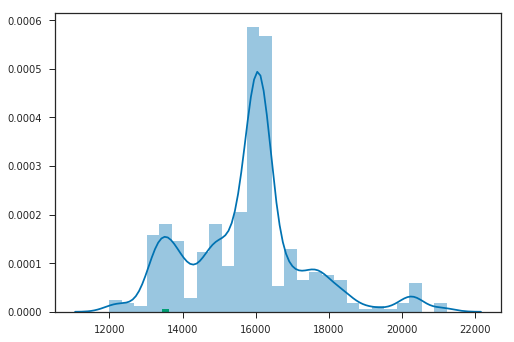

In [115]:
sns.distplot(shuf_odds)
plt.plot(true_odds,0,'s')

In [ ]:
right_isi[1:4]

In [ ]:
np.sum(swr_df.left.astype(bool) & swr_df.right.astype(bool))